In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import itertools as it
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import cmath


from finite_groups import *

from activation_funcs import *

In [4]:
# ==============================================================================
# SECTION 1: DEFINE GROUP (G = SL(2,5)/C2 ~= A5)
# ==============================================================================
def define_group():
    """
    Constructs SL(2,5) from generators, then constructs the quotient group 
    G = SL(2,5)/{-I, I} (which is A5).
    """
    
    # --- 1. Basic Permutation Helper ---
    def parse_cycle_str(cycle_str, n=24):
        perm = list(range(n))
        parts = cycle_str.split('(')
        for part in parts:
            if not part.strip(): continue
            nums = [int(x) for x in part.replace(')', '').replace('(', ' ').split()]
            if len(nums) > 1:
                mapping = {nums[i]-1: nums[(i+1)%len(nums)]-1 for i in range(len(nums))}
                new_perm = perm[:]
                for src, dst in mapping.items(): new_perm[src] = dst
                perm = new_perm
        return tuple(perm)

    def mult_raw(p, q): return tuple(p[x] for x in q)

    # --- 2. Generate Parent Group SL(2,5) ---
    print("Generating parent group SL(2, 5)...")
    gen1 = parse_cycle_str("(1 2 3 4)(5 6 7 8)(9 10 11 12)(13 14 15 16)(17 18 19 20)(21 22 23 24)")
    gen2 = parse_cycle_str("(1 14 19)(2 11 18)(3 16 17)(4 9 20)(5 6 12)(7 8 10)(13 24 21)(15 22 23)")
    generators = [gen1, gen2]
    
    parent_elements = set(generators)
    queue = deque(generators)
    identity = tuple(range(24))
    if identity not in parent_elements:
        parent_elements.add(identity)
        queue.append(identity)

    while queue:
        curr = queue.popleft()
        for g in generators:
            p = mult_raw(curr, g)
            if p not in parent_elements:
                parent_elements.add(p)
                queue.append(p)
            p2 = mult_raw(g, curr)
            if p2 not in parent_elements:
                parent_elements.add(p2)
                queue.append(p2)
    
    sorted_parent = sorted(list(parent_elements)) # Deterministic order
    print(f"Parent Group Order: {len(sorted_parent)} (Expected 120)")

    # --- 3. Construct Quotient Logic ---
    # Find the Central Element -I (Order 2)
    # In SL(2,5), -I is the unique element of order 2.
    neg_I = None
    for p in sorted_parent:
        if p == identity: continue
        # Check order 2
        if mult_raw(p, p) == identity:
            neg_I = p
            break
            
    if neg_I is None:
        raise ValueError("Could not find element of order 2 (-I) in parent group.")
    print(f"Found center element -I: {neg_I[:5]}...")

    # Build Map: Element -> Canonical Representative
    # We pair {g, -g} and pick the smaller one as representative
    parent_to_quotient = {}
    quotient_elements = []
    
    for g in sorted_parent:
        if g in parent_to_quotient: continue
        
        neg_g = mult_raw(neg_I, g)
        
        # Pick canonical (lexicographically smaller tuple)
        rep = g if g < neg_g else neg_g
        
        parent_to_quotient[g] = rep
        parent_to_quotient[neg_g] = rep
        
        if rep not in quotient_elements:
            quotient_elements.append(rep)

    print(f"Quotient Group Order: {len(quotient_elements)} (Expected 60)")

    # Define Quotient Multiplication
    # a * b = canonical( raw_mult(a, b) )
    def mult_quotient(p, q):
        raw_prod = mult_raw(p, q)
        return parent_to_quotient[raw_prod]

    # Store parent data in function attributes for subgroup projection later
    define_group.parent_elements = sorted_parent
    define_group.parent_mult = mult_raw
    define_group.parent_to_quotient = parent_to_quotient
    
    return quotient_elements, mult_quotient

# ==============================================================================
# SECTION 2: DEFINE SUBGROUP (Projected SL(2,3) -> A4)
# ==============================================================================
def define_subgroup(G: FiniteGroup):
    """
    Find SL(2,3) in parent, then project to quotient A4.
    """
    print("Searching for SL(2,3) in parent and projecting...")
    
    # Retrieve parent group helpers
    parent_elements = define_group.parent_elements
    parent_mult = define_group.parent_mult
    parent_to_quotient = define_group.parent_to_quotient
    
    # 1. Search for SL(2,3) (Order 24) in Parent
    import random
    
    # Map elements to indices for speed
    elem_to_idx = {e: i for i, e in enumerate(parent_elements)}
    
    max_attempts = 1000
    for _ in range(max_attempts):
        gens = random.sample(parent_elements, 2)
        subset_indices = {elem_to_idx[g] for g in gens}
        stack = list(subset_indices)
        
        over = False
        while stack:
            curr_i = stack.pop()
            curr = parent_elements[curr_i]
            for g_i in list(subset_indices):
                g = parent_elements[g_i]
                prod = parent_mult(curr, g)
                p_i = elem_to_idx[prod]
                if p_i not in subset_indices:
                    subset_indices.add(p_i)
                    stack.append(p_i)
                    if len(subset_indices) > 24: 
                        over = True
                        break
            if over: break
        
        if not over and len(subset_indices) == 24:
            print("Found SL(2,3) subgroup in parent.")
            sl23_elements = [parent_elements[i] for i in subset_indices]
            
            # 2. Project to Quotient
            projected = {parent_to_quotient[h] for h in sl23_elements}
            print(f"Projected Subgroup Order: {len(projected)} (Expected 12 for A4)")
            return list(projected)

    print("Failed to find subgroup.")
    return [G.identity]

# ==============================================================================
# SECTION 3: CONJUGACY CLASSES
# ==============================================================================
def define_conjugacy_classes():
    return None

# ==============================================================================
# SECTION 4: CHARACTER TABLE (A5 Table)
# ==============================================================================
def define_character_table(G: FiniteGroup):
    """
    A5 Character Table (Quotient of SL(2,5) by C2).
    """
    phi = (1 + sp.sqrt(5)) / 2
    phi_prime = (1 - sp.sqrt(5)) / 2  # 1-phi
    
    # A5 Table
    # Classes: 1A, 2A, 3A, 5A, 5B
    raw_data = {
        "1A": [1, 3, 3, 4, 5],
        "2A": [1, -1, -1, 0, 1],
        "3A": [1, 0, 0, 1, -1],
        "5A": [1, phi, phi_prime, -1, 0],
        "5B": [1, phi_prime, phi, -1, 0]
    }
    
    labels = ["1", "3", "3'", "4", "5"]

    print("Mapping A5 classes...")
    
    # Bucket G's classes by order
    classes_by_order = {}
    for cls in G.classes:
        # Determine order of representative
        rep_idx = G.elem_to_idx[G._key(cls.representative)]
        order = 1
        curr = rep_idx
        while True:
            if curr == G.identity_idx: break
            curr = G.mult_table[curr, rep_idx]
            order += 1
            if order > 200: break
        if order not in classes_by_order: classes_by_order[order] = []
        classes_by_order[order].append(cls)

    char_map = {}
    def pop_class(order):
        if order in classes_by_order and classes_by_order[order]:
            return classes_by_order[order].pop(0)
        return None

    # Map Orders to A5 Labels
    if c := pop_class(1): char_map[c.representative] = raw_data["1A"]
    if c := pop_class(2): char_map[c.representative] = raw_data["2A"]
    if c := pop_class(3): char_map[c.representative] = raw_data["3A"]
    
    # 5A and 5B
    if c1 := pop_class(5): char_map[c1.representative] = raw_data["5A"]
    if c2 := pop_class(5): char_map[c2.representative] = raw_data["5B"]

    return char_map, labels

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================
def run_analysis():
    print(">>> 1. Loading Group Data (Quotient)...")
    elements, mult_func = define_group()
    
    G = FiniteGroup(elements, mult_func, classes=define_conjugacy_classes())
    print(f"    Quotient Group Order: {G.n}")
    
    print("\n>>> 2. Loading Subgroup Data...")
    H_elements = define_subgroup(G)
    
    if len(H_elements) == 1: return

    solver = InducedRepSolver(G)
    solver.set_subgroup(H_elements)
    
    print("\n>>> 3. Loading Character Table...")
    char_map, labels = define_character_table(G)
    solver.load_character_table(char_map, irrep_labels=labels)
    
    print("\n>>> 4. Computing Exact Projectors...")
    solver.compute_projectors()
    
    print("\n>>> 5. Induced Representation Decomposition:")
    for label, Q in solver.Qblocks.items():
        if Q.shape[1] > 0:
            print(f"    Irrep '{label}' appears with dimension {Q.shape[1]}")
    
    print("\n>>> 6. Building Interaction Graph...")
    def relu_sym(x): return sp.Max(0, x)
    
    graph = solver.build_interaction_graph(activation_fn=relu_sym, verbose=True)
    if len(graph.nodes) > 0:
        plt.figure(figsize=(6, 6))
        pos = nx.spring_layout(graph, seed=42)
        nx.draw_networkx(graph, pos, node_color="#E8F0FF", edgecolors="blue", 
                         node_size=1000, font_weight="bold", with_labels=True)
        plt.title(f"Interaction Graph A5 (SL2F5/C2)")
        plt.show()


>>> 1. Loading Group Data (Quotient)...
Generating parent group SL(2, 5)...
Parent Group Order: 120 (Expected 120)
Found center element -I: (2, 3, 0, 1, 6)...
Quotient Group Order: 60 (Expected 60)
Building multiplication table for G (order 60)...
Discovering conjugacy classes...
    Quotient Group Order: 60

>>> 2. Loading Subgroup Data...
Searching for SL(2,3) in parent and projecting...
Found SL(2,3) subgroup in parent.
Projected Subgroup Order: 12 (Expected 12 for A4)
Computed 5 cosets for H (order 12) in G (order 60).

>>> 3. Loading Character Table...
Mapping A5 classes...
Character table loaded (SymPy).

>>> 4. Computing Exact Projectors...

>>> 5. Induced Representation Decomposition:
    Irrep '1' appears with dimension 1
    Irrep '4' appears with dimension 4

>>> 6. Building Interaction Graph...
Irreps present: ['1', '4']


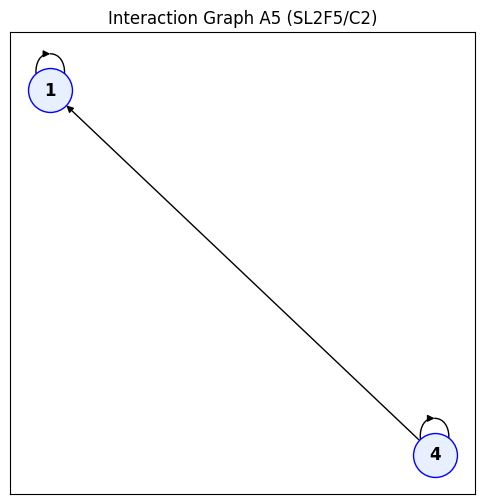

In [5]:
run_analysis()